<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will train a ConvNet to classify images from the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) database. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes (airplane, automobile,bird, cat, deer,dog, frog, horse, ship, truck), with 6000 images per class. There are 50000 training images and 10000 test images.

The process will be broken down into the following steps:

    1. Load and visualize the dataset
    2. Define a neural network
    3. Define a Loss function and optimizer
    4. Train the model on the training dataset
    5. Evaluate the performance of the trained model on the test dataset

In [1]:
# import required libraries
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if cuda in available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available")
else:
  print("CUDA is available")

device = torch.device('cuda') if train_on_gpu else torch.device('cpu')

CUDA is available


### Load and visualize the dataset

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


# convert the data to a normalized torch.FloatTensor
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

# choose the training and test dataset
train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# obtain training indices for creating a validation dataset
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
# choose percentage of training data for validation
valid_size = 0.2
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20


# prepare train, test and valid data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, num_workers=num_workers)

# specify image classes in the dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


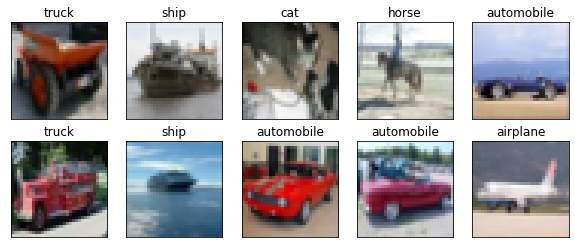

In [4]:
# visualize a batch of training data

def imshow(img):
  # unnormalize
  img = img / 2 + 0.5
  # convert from Tensor to image
  plt.imshow(np.transpose(img, (1,2,0)))

# obtain one batch on training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy() 

# plot the images in the batch along with the corresponding labels
fig = plt.figure(figsize=(10,4))
# display 10 images
for ind in np.arange(10):
  ax = fig.add_subplot(2, 10/2, ind+1, xticks=[], yticks=[])
  imshow(images[ind])
  ax.set_title(classes[labels[ind]])

### Define a neural network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # (sees 32x32x3 image tensor)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # (sees 16x16x16 tensor)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # (sees 8x8x32 tensor)

    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64*4*4, 500) 
    self.fc2 = nn.Linear(500, 10)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    # flatten image input
    x = x.view(-1, 64*4*4)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model = Net()
model.to(device)

print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Define loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

### Train the model on the training dataset

In [7]:
# helper function to calculate accuracy
def calc_acc(loader):
  correct, total = 0, 0
  for inputs, targets in loader:
    inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  # the class with the highest energy is what we choose as prediction
  _, predicted = torch.max(outputs, 1)
  total += targets.size(0)
  correct += (predicted==targets).sum().item()
  return ((100 * correct)/ total)

In [8]:
def training(epochs):
  train_loss, valid_loss = [], []
  train_acc, valid_acc = [], []

  # initialize trackers for min validation loss
  min_valid_loss = np.inf

  for epoch in range(epochs):
    running_train_loss = 0.0
    running_valid_loss = 0.0

    #--------- train the model -----------
    # prepare model for training
    model.train()
    for batch_idx, data in enumerate(train_loader):
      inputs, targets = data
      inputs, targets = inputs.to(device), targets.to(device)
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass
      outputs = model(inputs)
      # calculate the batch loss
      loss = criterion(outputs, targets)
      # backward loss
      loss.backward()
      # perform a single step
      optimizer.step()
      # update training loss
      running_train_loss += loss.item() 

    # ---------- validate the model ----------
    model.eval()
    for batch_idx, data in enumerate(valid_loader):
      inputs, targets = data
      inputs, targets = inputs.to(device), targets.to(device)
      # forward pass
      outputs = model(inputs)
      # calculate the batch loss
      loss = criterion(outputs, targets)
      # update validation loss
      running_valid_loss += loss.item()

    
    # calculate average losses over an epoch
    running_train_loss = running_train_loss / len(train_loader)
    running_valid_loss = running_valid_loss / len(valid_loader)

    train_loss.append(running_train_loss)
    valid_loss.append(running_valid_loss)

    train_acc.append(calc_acc(train_loader))
    valid_acc.append(calc_acc(valid_loader))

    print("Epochs: {} \tTraining loss: {:.6f} \tValidation loss: {:.6f}".format(epoch+1, running_train_loss, running_valid_loss))

    # save model if validation loss has decreased
    if running_valid_loss <= min_valid_loss:
      print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model ... ".format(
          min_valid_loss, running_valid_loss
      ))

      torch.save(model.state_dict(), 'model.pt')
      min_valid_loss = running_valid_loss

  print("Finished training!")

  return train_loss, valid_loss, train_acc, valid_acc

In [9]:
import time

num_epochs = 30

start = time.time()
train_loss, valid_loss, train_acc, valid_acc = training(num_epochs)
end = time.time()

print("%0.2f Minutes" % ((end - start)/60))

Epochs: 1 	Training loss: 2.064426 	Validation loss: 1.808883
Validation loss decreased (inf --> 1.808883). Saving model ... 
Epochs: 2 	Training loss: 1.668337 	Validation loss: 1.516200
Validation loss decreased (1.808883 --> 1.516200). Saving model ... 
Epochs: 3 	Training loss: 1.470021 	Validation loss: 1.349303
Validation loss decreased (1.516200 --> 1.349303). Saving model ... 
Epochs: 4 	Training loss: 1.355505 	Validation loss: 1.276846
Validation loss decreased (1.349303 --> 1.276846). Saving model ... 
Epochs: 5 	Training loss: 1.253562 	Validation loss: 1.185886
Validation loss decreased (1.276846 --> 1.185886). Saving model ... 
Epochs: 6 	Training loss: 1.172012 	Validation loss: 1.102645
Validation loss decreased (1.185886 --> 1.102645). Saving model ... 
Epochs: 7 	Training loss: 1.101494 	Validation loss: 1.061001
Validation loss decreased (1.102645 --> 1.061001). Saving model ... 
Epochs: 8 	Training loss: 1.038777 	Validation loss: 1.005884
Validation loss decreased 

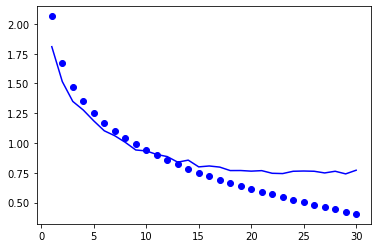

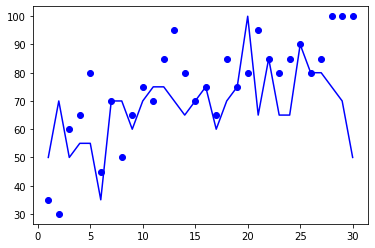

In [13]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_loss, 'bo', label="Training loss")
plt.plot(epochs, valid_loss, 'b', label="Validation loss")

plt.figure()

plt.plot(epochs, train_acc, 'bo', label="Training accuracy")
plt.plot(epochs, valid_acc, 'b', label="Validation accuracy")
plt.show()

### Evaluate the performance of the trained model on the test dataset

In [10]:
# load the model with the lowest validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>